In [1]:
%cd ../

/Users/harrysonghurst/Documents/Coursework/L48 Machine Learning and the Physical World/TrafficEmu


In [2]:
# If you get a SciPy error when installing Emukit, build it from source:

# git clone https://github.com/amzn/Emukit.git
# cd Emukit
# pip install -r requirements/requirements.txt
# python setup.py develop

In [3]:
import numpy as np
import pickle
import emukit as ek
import GPy

from emukit.model_wrappers import GPyModelWrapper
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign, latin_design
from emukit.experimental_design.acquisitions import ModelVariance, IntegratedVarianceReduction
from emukit.core.loop import UserFunctionWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.optimization import GradientAcquisitionOptimizer
import matplotlib.pyplot as plt
import seaborn as sns

from sumo_grid_simulation.grid_simulation import Simulator
import experimental_design.config as config

sns.set()

### Pseudocode

Fitting a gaussian process to a simulator using Emukit takes the following form (taken from L48 lectures):

```
initialize GP with some randomly chosen points
while stopping condition is not met:
    compute candidate point(s) using GP and acquisition funciton (model_variance) -> new point
    evaluate this new point with our simulator/user function -> observation
    update model with new observation -> new GP
```

### Simulator

In [4]:
simulator = Simulator(end_time=300)

### User Function
 
This is the function we want to understand. Namedly, how are CO2 emissions and timeLoss (the time lost due to driving below the ideal speed) affected by the following parameters: 

```
gridSize: the size of the grid network where the simulation is carried out
edgeMaxSpeed: legal speed limit in m/s - this can be exceeded (11.11 == 40km/h)
maxSpeed: the absolute maximum velocity of any vehicle in m/s (55.55 == 200 km/h)
edgeLength: length of the roads between intersections in meters
numLanes: number of lanes per road
accel: The acceleration ability of vehicles in m/s^2.
```

*A complete list of parmeters analysed is discussed in our report.*

In [5]:
def user_function(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            junctionType  = 1,
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        i += 1
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

### Model Inputs / parameter space

In [6]:
parameter_space = config.get_parameter_space()

### Get init and test points

In [7]:
design = RandomDesign(parameter_space)
init_X = design.get_samples(20)
init_Y = user_function(init_X)

design = RandomDesign(parameter_space)
test_X = design.get_samples(100)
test_Y = user_function(test_X)

[[ 8.          9.73874701 51.15180933  1.          2.34318169]
 [ 6.         14.18421693 38.7346495   3.          4.10454749]
 [11.         12.5492954  57.15560966  1.          4.01939099]
 [19.         16.74465913 63.46446526  1.          1.79440356]
 [18.         11.98889779 30.3172197   3.          2.66912147]
 [18.         15.60567804 58.46376005  1.          3.88390397]
 [19.         14.26184352 60.74430943  3.          4.37949936]
 [15.         14.94710473 66.05216907  1.          2.24561167]
 [10.         16.7512727  66.08688616  1.          3.29651882]
 [13.         13.64292984 62.76409016  3.          1.74462214]
 [ 7.         18.22351698 61.84743122  3.          4.4174711 ]
 [12.         17.01720978 38.6574999   1.          2.10786779]
 [17.          8.12611879 67.77323772  3.          1.51604951]
 [16.         16.13142126 41.06921653  3.          4.7924649 ]
 [18.          8.55094667 68.5346146   3.          3.68428527]
 [18.         15.60658085 57.10593319  2.          1.86

 Retrying in 1 seconds

Evaluating input: 2 of 100

 Retrying in 1 seconds

Evaluating input: 3 of 100

 Retrying in 1 seconds

Evaluating input: 4 of 100

 Retrying in 1 seconds

Evaluating input: 5 of 100

 Retrying in 1 seconds

Evaluating input: 6 of 100

 Retrying in 1 seconds

Evaluating input: 7 of 100

 Retrying in 1 seconds

Evaluating input: 8 of 100

 Retrying in 1 seconds

Evaluating input: 9 of 100

 Retrying in 1 seconds

Evaluating input: 10 of 100

 Retrying in 1 seconds

Evaluating input: 11 of 100

 Retrying in 1 seconds

Evaluating input: 12 of 100

 Retrying in 1 seconds

Evaluating input: 13 of 100

 Retrying in 1 seconds

Evaluating input: 14 of 100

 Retrying in 1 seconds

Evaluating input: 15 of 100

 Retrying in 1 seconds

Evaluating input: 16 of 100

 Retrying in 1 seconds

Evaluating input: 17 of 100

 Retrying in 1 seconds

Evaluating input: 18 of 100

 Retrying in 1 seconds

Evaluating input: 19 of 100

 Retrying in 1 seconds

Evaluating input: 20 of 100

 

### Experimental Design - Model Variance

In [8]:
MV_Xs = []
MV_Ys = []
mses_MV = []
    
def user_function_model_variance(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        MV_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        MV_Ys.append(s['timeLoss']/s['duration'])

        i += 1
    
    # evaluate / validate model
    if len(MV_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_mv.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_MV.append((len(MV_Xs), rmse))
        print('EVALUATED: ', len(MV_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

Our surrogate model is our emulator. In this case, a gaussian process.

In [9]:
emulator_mv = GPy.models.GPRegression(init_X, init_Y)
emukit_model_mv = GPyModelWrapper(emulator_mv, n_restarts=5)
emukit_model_mv.optimize()
emulator_mv

Optimization restart 1/5, f = -29.745759226939224
Optimization restart 2/5, f = 5.594422027103411
Optimization restart 3/5, f = -29.745759226942063
Optimization restart 4/5, f = -29.745759226939914
Optimization restart 5/5, f = -29.745759226926516


GP_regression.,value,constraints,priors
rbf.variance,0.15271824872539738,+ve,
rbf.lengthscale,23.064441546140415,+ve,
Gaussian_noise.variance,9.962040295687605e-05,+ve,


#### Acquisition Function

In [10]:
model_variance = ModelVariance(model=emukit_model_mv)

#### Optimizer

In [11]:
optimizer = GradientAcquisitionOptimizer(parameter_space)


#### Experimental Design Loop

In [12]:
ed_loop_mv = ExperimentalDesignLoop(
    model = emukit_model_mv,
    space = parameter_space,
    acquisition = model_variance,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [13]:
ed_loop_mv.run_loop(user_function_model_variance, 500)

Optimization restart 1/5, f = -29.745759226942063
Optimization restart 2/5, f = -29.74575922688841
Optimization restart 3/5, f = 5.594422027102436
Optimization restart 4/5, f = -29.745759226940883
Optimization restart 5/5, f = -29.74575922693127
[[ 3.  8. 70.  3.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -31.010308031091547
Optimization restart 2/5, f = 5.587051133831958
Optimization restart 3/5, f = 5.587050071786777
Optimization restart 4/5, f = -31.010308032075727
Optimization restart 5/5, f = -31.01030803236272
[[ 3.   8.  30.   1.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -32.05312369973355
Optimization restart 2/5, f = 5.680665772834715
Optimization restart 3/5, f = -31.762943804224513
Optimization restart 4/5, f = 5.680665772873338
Optimization restart 5/5, f = -32.05312369969

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds
Optimization restart 1/5, f = -38.72841335965252
Optimization restart 2/5, f = -38.34355204196507
Optimization restart 3/5, f = -38.34355204196569
Optimization restart 4/5, f = 9.57067940294107
Optimization restart 5/5, f = 9.570679402938753
[[20.          8.         50.16937639  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -39.097250132833906
Optimization restart 2/5, f = -39.09725013284182
Optimization restart 3/5, f = -37.08128964362976
Optimization restart 4/5, f = -39.097250132841296
Optimization restart 5/5, f = -39.0972501322734


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


[[ 3.  19.  30.   3.   1.5]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -39.50192659261057
Optimization restart 2/5, f = 11.048952540467068
Optimization restart 3/5, f = -39.50192659267269
Optimization restart 4/5, f = -39.501926575503944
Optimization restart 5/5, f = -39.501926592669044
[[ 3.  8. 70.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -41.47683288449106
Optimization restart 2/5, f = 11.060134025422784
Optimization restart 3/5, f = -41.47683288448777
Optimization restart 4/5, f = 11.060134078822998
Optimization restart 5/5, f = -41.476832884784734
[[ 3.          8.         51.60280357  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -43.606835801839786
Optimization res

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


 Retrying in 1 seconds
Optimization restart 1/5, f = -50.526648155697615
Optimization restart 2/5, f = -50.526648154785654
Optimization restart 3/5, f = -50.52664814596008
Optimization restart 4/5, f = -50.52664815551359
Optimization restart 5/5, f = 12.494229608942028
[[ 3. 19. 30.  1.  5.]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -52.800169563779704
Optimization restart 2/5, f = -53.77823302206829
Optimization restart 3/5, f = -53.77823281784123
Optimization restart 4/5, f = -53.778233129165656
Optimization restart 5/5, f = 4.549401446262554
[[ 3.         19.         47.23720333  1.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -51.98729509248137
Optimization restart 2/5, f = -51.98729509236864
Optimization restart 3/5, f = -51.987295092339686
Optimization restart 4/5, f = -5

 Retrying in 1 seconds
Optimization restart 1/5, f = -81.0824502700599
Optimization restart 2/5, f = 12.053079196442727
Optimization restart 3/5, f = -81.08245027081387
Optimization restart 4/5, f = 12.053077247497136
Optimization restart 5/5, f = 12.053077257977058
[[ 3.         11.7077564  62.38443714  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -82.70022064957104
Optimization restart 2/5, f = -82.70022064911106
Optimization restart 3/5, f = -82.70022022259036
Optimization restart 4/5, f = 12.135982540255743
Optimization restart 5/5, f = -82.7002206439058
[[ 3.         10.64283288 30.          1.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -84.35757824074317
Optimization restart 2/5, f = -84.35757824080576
Optimization restart 3/5, f = -84.3575781027931

 Retrying in 1 seconds
Optimization restart 1/5, f = -123.75343582472199
Optimization restart 2/5, f = -115.26318522527193
Optimization restart 3/5, f = -115.26315989246703
Optimization restart 4/5, f = -115.26318536368878
Optimization restart 5/5, f = 20.54153809709188
[[ 3.         16.96776021 55.00747325  3.          5.        ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -126.0858392205807
Optimization restart 2/5, f = -116.78516677168327
Optimization restart 3/5, f = -116.7851666196104
Optimization restart 4/5, f = -116.78516676907725
Optimization restart 5/5, f = -116.785165342554
[[20.         11.96165649 40.52923358  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -128.59028229927304
Optimization restart 2/5, f = -128.59028229955018
Optimization restart 3/5, f = -118.7724

Optimization restart 3/5, f = -139.68890346060587
Optimization restart 4/5, f = -139.68890326791288
Optimization restart 5/5, f = -139.68890375075006
[[20.         12.86485702 69.91274087  3.          3.35958788]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -172.59291186108084
Optimization restart 2/5, f = -172.59291186465805
Optimization restart 3/5, f = -172.59291186466106
Optimization restart 4/5, f = -172.592911864403
Optimization restart 5/5, f = -143.3249776651619
[[ 3.          8.         44.08754437  3.          1.5       ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -175.42513038579074
Optimization restart 2/5, f = 29.713917378122822
Optimization restart 3/5, f = -175.42513038578386
Optimization restart 4/5, f = 29.71391721521902
Optimization restart 5/5, f = -146.9570036216406
[[ 9.        

Optimization restart 4/5, f = -180.13509565112804
Optimization restart 5/5, f = -218.59003411108628
[[ 8.          9.05808758 69.49414767  3.          4.77355894]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -221.4328533333251
Optimization restart 2/5, f = -221.43288168366
Optimization restart 3/5, f = -181.91784547225996
Optimization restart 4/5, f = -181.91784470919674
Optimization restart 5/5, f = 36.783153125669706
[[10.          8.02853529 69.66667036  1.          1.71756006]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -224.32461319827718
Optimization restart 2/5, f = 36.729001073483055
Optimization restart 3/5, f = -185.58488551605586
Optimization restart 4/5, f = -185.5839282030717
Optimization restart 5/5, f = -185.58488549791633
[[20.         12.20692718 30.14119444  1.          1.75853024]]

 Retrying in 1 seconds
Optimization restart 1/5, f = -265.7820367716838
Optimization restart 2/5, f = -265.78224025887954
Optimization restart 3/5, f = -265.78224025871486
Optimization restart 4/5, f = -219.47986470474592
Optimization restart 5/5, f = -219.47986250434877
[[20.          8.4272435  59.62415232  1.          4.58888506]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -268.6478140238265
Optimization restart 2/5, f = -268.6478140244853
Optimization restart 3/5, f = -222.83103825049236
Optimization restart 4/5, f = -222.8310383054774
Optimization restart 5/5, f = -268.6478140241957
[[ 3.         13.79342056 30.44746047  3.          1.90343943]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -270.32987597497896
Optimization restart 2/5, f = -226.88566453837564
Optimization restart 3/5, f = -270.329

 Retrying in 1 seconds
Optimization restart 1/5, f = -315.46592087990746
Optimization restart 2/5, f = -315.46592088487307
Optimization restart 3/5, f = -269.2331523500383
Optimization restart 4/5, f = -269.2331409535873
Optimization restart 5/5, f = -315.4659208532003
[[10.          8.22266439 45.76689385  3.          4.87141976]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -318.4462149715571
Optimization restart 2/5, f = -318.44634875937095
Optimization restart 3/5, f = -318.44634876006245
Optimization restart 4/5, f = -318.4463487586205
Optimization restart 5/5, f = -318.4463487601182
[[20.          8.19260456 43.55478926  1.          1.64369358]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -320.8119677142161
Optimization restart 2/5, f = -320.81196771855593
Optimization restart 3/5, f = -320.81196

 Retrying in 1 seconds
Optimization restart 1/5, f = -365.8168176890696
Optimization restart 2/5, f = 49.177569496375014
Optimization restart 3/5, f = -365.81704373620715
Optimization restart 4/5, f = -294.51976341031656
Optimization restart 5/5, f = -294.5199002463131
[[14.         18.69191454 58.48213748  3.          4.98341467]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -368.8283183452078
Optimization restart 2/5, f = -368.82831834540673
Optimization restart 3/5, f = -368.8283183452355
Optimization restart 4/5, f = -297.1755907488821
Optimization restart 5/5, f = -368.8283183455151
[[ 3.         18.8941354  54.02895136  1.          4.98981533]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -370.8370209230983
Optimization restart 2/5, f = -370.8370209235978
Optimization restart 3/5, f = -370.8370209

 Retrying in 1 seconds
Optimization restart 1/5, f = -416.90822565257605
Optimization restart 2/5, f = -416.9082256545208
Optimization restart 3/5, f = -416.908225652039
Optimization restart 4/5, f = -323.694792806264
Optimization restart 5/5, f = -416.9082256548011
[[ 9.         11.08802476 30.11418043  3.          1.62545445]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -417.85226195919927
Optimization restart 2/5, f = -417.85226195151057
Optimization restart 3/5, f = -417.8522619620252
Optimization restart 4/5, f = -417.85226196153417
Optimization restart 5/5, f = -417.85226196229837
[[ 3.         12.30367526 59.35150561  1.          1.60876945]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -420.5466652106618
Optimization restart 2/5, f = -420.5466652095183
Optimization restart 3/5, f = -420.5466651

 Retrying in 1 seconds
Optimization restart 1/5, f = -463.93286624881677
Optimization restart 2/5, f = -348.42133769329564
Optimization restart 3/5, f = -463.9328662485086
Optimization restart 4/5, f = -348.4213503230738
Optimization restart 5/5, f = -463.9328662306694
[[16.          8.33909302 49.96193996  1.          4.93511531]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -467.06123837505027
Optimization restart 2/5, f = -467.0612383774361
Optimization restart 3/5, f = -467.06123835335177
Optimization restart 4/5, f = -350.5588919170214
Optimization restart 5/5, f = -467.061238373681
[[ 3.         14.19335876 61.56555876  3.          1.55557137]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -469.7204653281682
Optimization restart 2/5, f = -469.7204653292957
Optimization restart 3/5, f = -469.7204653

[[20.         13.78514887 60.68231088  3.          1.52457656]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -524.3874678208913
Optimization restart 2/5, f = -524.3876204678916
Optimization restart 3/5, f = -524.3876204643327
Optimization restart 4/5, f = -524.3876204678046
Optimization restart 5/5, f = -394.2743619755946
[[ 9.         18.99180286 69.79137004  3.          1.55464607]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -527.5721712360728
Optimization restart 2/5, f = -398.02538970198725
Optimization restart 3/5, f = -527.5726655339397
Optimization restart 4/5, f = -527.5726655259116
Optimization restart 5/5, f = -527.5726655301813
[[20.         10.3713967  30.16144417  1.          3.38917263]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 s

Optimization restart 4/5, f = -569.1030094729805
Optimization restart 5/5, f = -569.1030094739076
[[14.         11.59428428 69.73709343  1.          1.54924952]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -572.2523708028083
Optimization restart 2/5, f = -572.2532374949521
Optimization restart 3/5, f = -572.2532374923762
Optimization restart 4/5, f = -572.2532356646079
Optimization restart 5/5, f = -572.2532374995544
[[15.         12.61835379 46.06917644  3.          1.50114896]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -575.5830997278467
Optimization restart 2/5, f = -575.5833139319694
Optimization restart 3/5, f = -575.5833139334999
Optimization restart 4/5, f = -575.5833132783059
Optimization restart 5/5, f = -575.5833139261894
[[ 9.          8.01170533 52.7303841   1.          4.82202801]]

Use

 Retrying in 1 seconds
Optimization restart 1/5, f = -632.2397258960809
Optimization restart 2/5, f = -632.2397258934225
Optimization restart 3/5, f = -498.2384746692975
Optimization restart 4/5, f = -632.2397258971463
Optimization restart 5/5, f = -632.2397258955941
[[ 3.         14.11527283 30.73016713  1.          1.50390025]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -635.5440314442341
Optimization restart 2/5, f = -635.5440796873769
Optimization restart 3/5, f = -635.5440796910367
Optimization restart 4/5, f = -635.5440796933356
Optimization restart 5/5, f = -635.5440796878041
[[ 3.         15.13178319 63.24432489  1.          4.87706841]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -638.7571096784204
Optimization restart 2/5, f = -638.7571096752392
Optimization restart 3/5, f = -638.7571096767

 Retrying in 1 seconds
Optimization restart 1/5, f = -675.1095119418743
Optimization restart 2/5, f = -675.1096006021996
Optimization restart 3/5, f = -675.1095991742388
Optimization restart 4/5, f = -675.1096006183411
Optimization restart 5/5, f = -675.109600620903
[[20.          8.23287307 30.75367635  1.          1.56686566]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -678.3080301324928
Optimization restart 2/5, f = -449.47265649877977
Optimization restart 3/5, f = -678.308093518421
Optimization restart 4/5, f = -678.3080928510365
Optimization restart 5/5, f = -678.3080936069721
[[20.          8.07497358 30.16596822  3.          3.93303687]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -681.4664620683463
Optimization restart 2/5, f = -681.4671070168145
Optimization restart 3/5, f = -681.46710681095

 Retrying in 1 seconds
Optimization restart 1/5, f = -736.0780634417379
Optimization restart 2/5, f = -736.0780634441021
Optimization restart 3/5, f = -736.0780634121452
Optimization restart 4/5, f = -736.0780634441045
Optimization restart 5/5, f = -736.078063444226
[[10.         18.7876722  56.3101417   3.          1.53245199]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -739.3262566695767
Optimization restart 2/5, f = -739.3262567643214
Optimization restart 3/5, f = -739.326256752886
Optimization restart 4/5, f = -739.3262567618173
Optimization restart 5/5, f = -739.3262567665581
[[17.          8.0698407  50.50193902  1.          1.53824068]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -742.6704541321773
Optimization restart 2/5, f = -742.6704635585023
Optimization restart 3/5, f = -742.670463868500

 Retrying in 1 seconds
Optimization restart 1/5, f = -790.7016710206092
Optimization restart 2/5, f = -790.702443866114
Optimization restart 3/5, f = -790.7024438660237
Optimization restart 4/5, f = -790.702443871005
Optimization restart 5/5, f = -790.7024438724532
[[14.          8.19308245 67.98539844  1.          4.98762417]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -794.0262573943512
Optimization restart 2/5, f = -794.0262638089279
Optimization restart 3/5, f = -794.0262637961093
Optimization restart 4/5, f = -794.0262638070883
Optimization restart 5/5, f = -794.0262638014113
[[20.         15.4378807  51.06941423  1.          4.92323178]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -797.0672270092227
Optimization restart 2/5, f = -797.0676488589891
Optimization restart 3/5, f = -797.067648858926

 Retrying in 1 seconds
Optimization restart 1/5, f = -853.5933618141942
Optimization restart 2/5, f = -853.5933710734784
Optimization restart 3/5, f = -853.5933710715932
Optimization restart 4/5, f = -853.5933710734096
Optimization restart 5/5, f = -853.5933705362163
[[13.         18.88376529 46.7290425   1.          4.97988427]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -856.6951242013133
Optimization restart 2/5, f = -856.695246270307
Optimization restart 3/5, f = -856.6952462330638
Optimization restart 4/5, f = -856.6952462713745
Optimization restart 5/5, f = -856.6952462632954
[[14.         18.98928546 37.35046266  1.          1.62071459]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -860.0629481324212
Optimization restart 2/5, f = -860.0629480643855
Optimization restart 3/5, f = -860.06294820437

 Retrying in 1 seconds
Optimization restart 1/5, f = -912.3821295063284
Optimization restart 2/5, f = -912.3821307976332
Optimization restart 3/5, f = -912.3821307427493
Optimization restart 4/5, f = -912.3821308081726
Optimization restart 5/5, f = -912.3821308127992
[[20.         13.84709007 48.63684051  3.          1.50236356]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -915.7670961986537
Optimization restart 2/5, f = -915.7670926256774
Optimization restart 3/5, f = -915.7670995196611
Optimization restart 4/5, f = -915.7670995571013
Optimization restart 5/5, f = -915.7670995633989
[[17.         18.79969525 69.95227656  3.          2.9606807 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -919.1261366805369
Optimization restart 2/5, f = -919.1262167956263
Optimization restart 3/5, f = -919.1262162971

 Retrying in 1 seconds
Optimization restart 1/5, f = -977.5645563800116
Optimization restart 2/5, f = -977.5646041822603
Optimization restart 3/5, f = -977.5646041553732
Optimization restart 4/5, f = -977.5646041436464
Optimization restart 5/5, f = -977.5646041820031
[[ 3.         12.89986759 47.27711364  3.          4.86587538]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -980.5258639328342
Optimization restart 2/5, f = -980.5259294109966
Optimization restart 3/5, f = -980.5259294173048
Optimization restart 4/5, f = -980.5259294067951
Optimization restart 5/5, f = -980.5259294071913
[[20.          8.07854038 34.9245605   3.          1.75573148]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -981.3804416614507
Optimization restart 2/5, f = -981.3848835585716
Optimization restart 3/5, f = -981.3848835792

 Retrying in 1 seconds
Optimization restart 1/5, f = -1041.3671591056604
Optimization restart 2/5, f = -1041.367165018397
Optimization restart 3/5, f = -1041.3671650190024
Optimization restart 4/5, f = -1041.3671648624122
Optimization restart 5/5, f = -1041.3671650111487
[[14.         10.85862088 36.83192674  2.          1.5343849 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1044.7813310540932
Optimization restart 2/5, f = -1044.7813310769363
Optimization restart 3/5, f = -1044.781331182119
Optimization restart 4/5, f = -1044.78132883567
Optimization restart 5/5, f = -1044.7813311885052
[[20.         14.80909013 69.44139676  2.          4.83716021]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1048.109834051423
Optimization restart 2/5, f = -1048.1105846929406
Optimization restart 3/5, f = -1048.11

Optimization restart 4/5, f = -1087.1367429251984
Optimization restart 5/5, f = -1087.136742921974
[[ 9.         15.27175695 49.26801375  3.          4.99359584]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1090.4346824028096
Optimization restart 2/5, f = -1090.4348431144972
Optimization restart 3/5, f = -1090.4348431104015
Optimization restart 4/5, f = -1090.4348431088383
Optimization restart 5/5, f = -1090.4348431100605
[[ 8.         18.75679808 44.98461516  3.          1.54661859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1093.8402236553154
Optimization restart 2/5, f = -1093.8402556329036
Optimization restart 3/5, f = -1093.8402556396752
Optimization restart 4/5, f = -1093.8402556269289
Optimization restart 5/5, f = -1093.8402556455208
[[ 3.         18.8905531  69.48111018  3.          1.6317

 Retrying in 1 seconds
Optimization restart 1/5, f = -1145.3183901469197
Optimization restart 2/5, f = -1145.3183920681672
Optimization restart 3/5, f = -1145.3183920665665
Optimization restart 4/5, f = -1145.3183920531635
Optimization restart 5/5, f = -1145.3183920476577
[[ 3.         11.53175451 30.03910951  1.          1.59379541]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1148.6757185049169
Optimization restart 2/5, f = -1148.6757196550095
Optimization restart 3/5, f = -1148.6757195775738
Optimization restart 4/5, f = -1148.675719612944
Optimization restart 5/5, f = -1148.6757196456929
[[ 3.         18.80699763 30.56417994  1.          2.11136919]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1151.8422516877029
Optimization restart 2/5, f = -1151.8422683392434
Optimization restart 3/5, f = -115

Optimization restart 4/5, f = -1205.4620738535516
Optimization restart 5/5, f = -1205.4620738411036
[[ 3.         12.47201034 69.94549365  3.          4.90591963]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1208.755837403618
Optimization restart 2/5, f = -1208.7559304569606
Optimization restart 3/5, f = -1208.7559304691592
Optimization restart 4/5, f = -1208.7559302252869
Optimization restart 5/5, f = -1208.7559300189857
[[10.         18.97825357 36.27008737  3.          1.50466825]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1209.198288858068
Optimization restart 2/5, f = -1209.2028985532352
Optimization restart 3/5, f = -1209.2028985491102
Optimization restart 4/5, f = -1209.2028985493343
Optimization restart 5/5, f = -1209.2028985552822
[[ 3.          8.03622912 53.59145091  1.          4.46081

 Retrying in 1 seconds
Optimization restart 1/5, f = -1261.8683869877866
Optimization restart 2/5, f = -1261.8710297551931
Optimization restart 3/5, f = -1261.8710299812471
Optimization restart 4/5, f = -1261.8710299613297
Optimization restart 5/5, f = -1261.8710299743184
[[ 3.         15.21844955 30.63023157  3.          1.51711804]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1265.0877306898283
Optimization restart 2/5, f = -1265.0887332835596
Optimization restart 3/5, f = -1265.0887333185133
Optimization restart 4/5, f = -1265.0887333179178
Optimization restart 5/5, f = -1265.0887333061298
[[16.          8.01836046 41.60846324  1.          1.73943181]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1267.8189798294745
Optimization restart 2/5, f = -1267.8190835768569
Optimization restart 3/5, f = -12

Optimization restart 5/5, f = -1321.483820862359
[[20.         17.87940149 30.22362985  3.          1.82319385]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1323.315959292598
Optimization restart 2/5, f = -1323.3159586638021
Optimization restart 3/5, f = -1323.3159593220507
Optimization restart 4/5, f = -1323.3159593236019
Optimization restart 5/5, f = -1323.3159593224968
[[20.         12.12861759 40.03741886  3.          1.64020747]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1326.2489534010797
Optimization restart 2/5, f = -1326.248953393707
Optimization restart 3/5, f = -1326.2489505113363
Optimization restart 4/5, f = -1326.248953388568
Optimization restart 5/5, f = -1326.2489534000842
[[10.          8.11822958 30.30196729  1.          1.67770394]]

User function time loss called with 1 inputs 

### Experimental Design - Integrated Variance Reduction

In [14]:
IVR_Xs = []
IVR_Ys = []
mses_IVR = []
    
def user_function_integrated_variance_reduction(X):
    """  X = inputs - emukit doesnt pass named args, just an NxM ndarray, N is the number of points to evaluate, M is the number of parameters per each point """
    result = []
    i = 0
    
    print(X)
    print(f'\nUser function time loss called with {X.shape[0]} inputs to simulate')

    
    for gridSize, edgeMaxSpeed, edgeLength, numLanes, accel in X:
        print(f'\nEvaluating input: {i+1} of {X.shape[0]}\n')
        
        beta = 0.05
        max_number_of_vehicles = ((gridSize - 1) * gridSize * 2 + 4 * gridSize) * edgeLength / 5
        period = 300/(max_number_of_vehicles * beta)
        
        s = simulator.simulate(
            gridSize      = int(gridSize),
            edgeMaxSpeed  = edgeMaxSpeed,
            edgeLength    = edgeLength,
            numberOfLanes = int(numLanes),
            accel         = accel,
            trips_generator_period = period
        )
        # average time loss / average route duration
        result.append(s['timeLoss']/s['duration'])
        IVR_Xs.append([int(gridSize), edgeMaxSpeed, edgeLength, int(numLanes), accel])
        IVR_Ys.append(s['timeLoss']/s['duration'])

        i += 1
    
    # evaluate / validate model
    if len(IVR_Xs) % 50 == 0:
        pred_Y, pred_Y_variance = emukit_model_ivr.predict(np.array(test_X))
        rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
        mses_IVR.append((len(IVR_Xs), rmse))
        print('EVALUATED: ', len(IVR_Xs), rmse)
        
    # expand dims is essential or the acquition function breaks
    return np.expand_dims(np.array(result), 1)  

#### Model / Emulator (GP)

In [15]:
emulator_ivr = GPy.models.GPRegression(init_X, init_Y)
emukit_model_ivr = GPyModelWrapper(emulator_ivr, n_restarts=5)
emukit_model_ivr.optimize()

Optimization restart 1/5, f = -29.745759226939224
Optimization restart 2/5, f = -29.745759226933803
Optimization restart 3/5, f = -29.74575922694189
Optimization restart 4/5, f = -29.74575922693721
Optimization restart 5/5, f = -27.88339439204875


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


#### Acquisition Function

In [16]:
integrated_variance_reduction = IntegratedVarianceReduction(
    model=emukit_model_ivr, 
    space=parameter_space, 
    num_monte_carlo_points=100
)

#### Optimizer

In [17]:
optimizer = GradientAcquisitionOptimizer(parameter_space)

#### Experimental Design Loop

In [18]:
ed_loop_ivr = ExperimentalDesignLoop(
    model = emukit_model_ivr,
    space = parameter_space,
    acquisition = integrated_variance_reduction,
    acquisition_optimizer = optimizer,
    batch_size = 1
)

In [19]:
ed_loop_ivr.run_loop(user_function_integrated_variance_reduction, 500)

Optimization restart 1/5, f = -29.74575922694189
Optimization restart 2/5, f = -29.745759224922455
Optimization restart 3/5, f = -29.745759221681816
Optimization restart 4/5, f = -29.745759226859633
Optimization restart 5/5, f = -29.745759226940223
[[10.          8.29098894 35.3439112   2.          2.94963888]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -30.713941809639103
Optimization restart 2/5, f = -30.71394180963986
Optimization restart 3/5, f = -30.713941805833453
Optimization restart 4/5, f = -28.544357233326735
Optimization restart 5/5, f = -30.713941809550484
[[ 4.          9.64494158 62.89042595  1.          2.38328847]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -32.39843477616114
Optimization restart 2/5, f = -32.39843477630432
Optimization restart 3/5, f = 5.451388297283012
Optimization

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -51.968973284101786
[[ 3.          8.09365514 52.59424983  2.          1.8107937 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -53.81956179494033
Optimization restart 2/5, f = 10.442502422679905
Optimization restart 3/5, f = 10.442503987994694
Optimization restart 4/5, f = -53.81956179493802
Optimization restart 5/5, f = -53.81956169943392
[[20.         17.27063585 31.28153953  3.          2.55471767]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -55.58390759871125
Optimization restart 2/5, f = -55.584744198598145
Optimization restart 3/5, f = -55.58474419885293
Optimization restart 4/5, f = -55.584744200250505
Optimization restart 5/5, f = -55.58474419937336
[[20.         18.54514045 69.39250622  3.          2.06068551]]

User function time loss called with 1 inputs to s

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = 12.944130856898706
[[18.          8.01831037 48.85793093  2.          4.76598123]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -60.61950556563554
Optimization restart 2/5, f = -60.620088372183304
Optimization restart 3/5, f = -60.62008837206933
Optimization restart 4/5, f = -60.62008837216916
Optimization restart 5/5, f = -58.28528336922733


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 6.          8.63492744 30.74539654  3.          2.40459897]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -62.27388253980659
Optimization restart 2/5, f = -62.27388253980011
Optimization restart 3/5, f = 13.238119544737096
Optimization restart 4/5, f = -62.273882539811375
Optimization restart 5/5, f = 13.238119558651618
[[20.          8.50592858 68.74142931  2.          1.64477675]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -64.39425111809443
Optimization restart 2/5, f = -64.39425111886118
Optimization restart 3/5, f = 13.141871932525166
Optimization restart 4/5, f = -64.39425111899742
Optimization restart 5/5, f = -64.39425108751851
[[20.          8.10356357 33.19706419  3.          1.78203315]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 s

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[11.          8.19007403 48.44642485  3.          4.90972716]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -69.88300636608224
Optimization restart 2/5, f = 14.289718243193143
Optimization restart 3/5, f = -69.8872679800305
Optimization restart 4/5, f = -69.88726797950827
Optimization restart 5/5, f = -69.88726797703285
[[ 3.          8.29389366 67.79537557  1.          1.53194588]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -71.99269927260536
Optimization restart 2/5, f = -71.99598676516294
Optimization restart 3/5, f = -71.99598676414462
Optimization restart 4/5, f = -71.9959867652071
Optimization restart 5/5, f = -71.9959867651087
[[ 4.         18.85522807 45.3438406   3.          4.91756555]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 secon

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 3.         18.22717286 69.64136847  1.          4.18694132]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -89.27583204968381
Optimization restart 2/5, f = -86.06412172691374
Optimization restart 3/5, f = 17.831504999661888
Optimization restart 4/5, f = -86.06412172700428
Optimization restart 5/5, f = -87.5643152651012


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[20.         18.36068476 30.9547539   3.          2.33237258]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -91.54838359919691
Optimization restart 2/5, f = 18.821848371414088
Optimization restart 3/5, f = -88.4163626897481
Optimization restart 4/5, f = -88.41636268978665
Optimization restart 5/5, f = -88.41636266010593
[[ 3.         10.68950346 30.88942647  3.          4.18652806]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -93.85431922925335
Optimization restart 2/5, f = -91.09427951481683
Optimization restart 3/5, f = -91.09427951481446
Optimization restart 4/5, f = -91.0942795145654
Optimization restart 5/5, f = -91.09427951471666
[[19.          9.79309481 69.66394811  3.          4.7314444 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seco

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -124.43480783292719
Optimization restart 5/5, f = -124.88344738434418
[[13.         12.98625466 31.92722568  2.          4.4283562 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -126.22746289426644
Optimization restart 2/5, f = -126.22746289447602
Optimization restart 3/5, f = -126.22746289201811
Optimization restart 4/5, f = -126.22746289449242
Optimization restart 5/5, f = -126.22746289326693
[[ 4.         14.32681362 38.88686768  1.          2.04933682]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -127.88262052689878
Optimization restart 2/5, f = -127.88262052650734
Optimization restart 3/5, f = -127.88262042976493
Optimization restart 4/5, f = -127.88262052688933
Optimization restart 5/5, f = -127.88262040653152
[[12.         14.91220552 69.91447264  3.          3.290

 Retrying in 1 seconds
Optimization restart 1/5, f = -172.9017401902594
Optimization restart 2/5, f = -172.90174018852977


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -172.90174019023425
Optimization restart 4/5, f = -172.90174018912333
Optimization restart 5/5, f = -172.90174018728763
[[11.         14.00577434 69.55924016  3.          2.46168928]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -175.74749490754985
Optimization restart 2/5, f = -175.74749491031844
Optimization restart 3/5, f = -175.74749490890483
Optimization restart 4/5, f = -175.74749490863104
Optimization restart 5/5, f = -175.74749491024787
[[12.         13.75137046 35.68852854  1.          1.73782704]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -177.96001206461403
Optimization restart 2/5, f = -177.96001204733037
Optimization restart 3/5, f = -177.96001206466394
Optimization restart 4/5, f = -177.96001206482958
Optimization restart 5/5, f = -177.96001206484465
[[12. 

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -182.44815643701622
Optimization restart 4/5, f = -182.44815640141897
Optimization restart 5/5, f = -182.44815643708512
[[12.         17.17278298 30.81505161  3.          4.91674964]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -185.19829252275233
Optimization restart 2/5, f = -185.19829252355265
Optimization restart 3/5, f = -185.19829252340503
Optimization restart 4/5, f = -185.19829252331132
Optimization restart 5/5, f = -185.1982925237792
[[ 9.         17.08563302 50.43542728  1.          4.99967264]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -187.8125924460674
Optimization restart 2/5, f = -187.81259244758763
Optimization restart 3/5, f = -187.81259244758428
Optimization restart 4/5, f = -187.8125924475881
Optimization restart 5/5, f = -187.81259244758434
[[ 3.    

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -188.09300941698123
[[11.          8.43457978 37.96067237  2.          4.53371016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -193.37307933817425
Optimization restart 2/5, f = -193.37307933819352


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -193.37307933820335
Optimization restart 4/5, f = -193.3730793382017
Optimization restart 5/5, f = -193.37307933818312
[[20.         12.43353508 42.5075329   3.          1.79066016]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -195.57871290355064
Optimization restart 2/5, f = -195.57871289409297
Optimization restart 3/5, f = -195.57871290311152
Optimization restart 4/5, f = -188.79669395541987
Optimization restart 5/5, f = -195.57871290374482


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


[[ 9.         18.83651192 64.33362124  1.          1.89202339]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -198.34059781019351
Optimization restart 2/5, f = -198.3405978113629
Optimization restart 3/5, f = -198.34059779887554
Optimization restart 4/5, f = -198.3405978110951
Optimization restart 5/5, f = -198.34059781137705
[[16.         13.10673934 69.99986533  3.          4.11568297]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -201.24515231804355
Optimization restart 2/5, f = -201.24516219779025
Optimization restart 3/5, f = -201.2451621965223
Optimization restart 4/5, f = -201.24516219850608
Optimization restart 5/5, f = -201.2451621985116
[[16.         18.53528078 57.7901603   3.          4.68804159]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying i

Optimization restart 3/5, f = -249.94863519100323
Optimization restart 4/5, f = -249.9486351908418
Optimization restart 5/5, f = -249.9486351832739
[[12.         12.81120639 46.49732896  3.          1.83385243]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -249.33378571076946
Optimization restart 2/5, f = -249.3337857357104
Optimization restart 3/5, f = -249.3337857315557
Optimization restart 4/5, f = -249.33378573626794
Optimization restart 5/5, f = -249.33378573583803
[[13.         15.07368247 69.79435197  1.          1.91202593]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -252.17767557451197
Optimization restart 2/5, f = -252.1776762051383
Optimization restart 3/5, f = -252.17767620508477
Optimization restart 4/5, f = -252.1776762051376
Optimization restart 5/5, f = 37.815819853227616
[[20.        

 Retrying in 1 seconds
Optimization restart 1/5, f = -298.4949691860859
Optimization restart 2/5, f = -298.49500122249236
Optimization restart 3/5, f = -298.49500122214477
Optimization restart 4/5, f = -298.49500122129314
Optimization restart 5/5, f = -298.49500119850694
[[15.         13.08010329 50.15513641  1.          1.68244201]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -301.56684771360824
Optimization restart 2/5, f = -301.56685409355833
Optimization restart 3/5, f = -301.5668541117709
Optimization restart 4/5, f = 43.59501593301417
Optimization restart 5/5, f = -301.5668538832882
[[19.          8.07091041 38.99588839  3.          3.83752879]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -304.52934273160196
Optimization restart 2/5, f = -304.5293427303916
Optimization restart 3/5, f = -304.5293

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -332.35468046333466
Optimization restart 4/5, f = -332.3546804642068
Optimization restart 5/5, f = -332.35468046427343
[[ 5.         11.92865287 30.17394462  3.          1.53000069]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -335.05239430952975
Optimization restart 2/5, f = -335.0526161283217
Optimization restart 3/5, f = -335.0526159873402
Optimization restart 4/5, f = -335.05261612688395
Optimization restart 5/5, f = -335.05261611871356
[[20.         18.56282324 55.87688678  1.          4.0173779 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -337.8485474913034
Optimization restart 2/5, f = 48.06601452221133
Optimization restart 3/5, f = -337.8485511904886
Optimization restart 4/5, f = -337.8485511564353
Optimization restart 5/5, f = -337.8485511911722
[[ 6.         1

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -377.2158635871122
Optimization restart 4/5, f = -377.2158637836778
Optimization restart 5/5, f = -377.21586378938593
[[ 7.         13.30057679 51.70059614  2.          3.42167019]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -379.99654811316367
Optimization restart 2/5, f = -379.99654804685497
Optimization restart 3/5, f = -379.99654811267453
Optimization restart 4/5, f = -379.9965480530483


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -379.996548112358
[[20.         12.34356437 62.9481536   3.          1.65454242]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -382.3181888968229
Optimization restart 2/5, f = -382.31879075198094
Optimization restart 3/5, f = -382.31879063880035
Optimization restart 4/5, f = -382.31879074881294
Optimization restart 5/5, f = -382.3187907192382
[[ 6.          8.24623702 30.44695945  3.          4.12946537]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -383.48584739526615
Optimization restart 2/5, f = -383.48584735162433
Optimization restart 3/5, f = -383.48584644442195
Optimization restart 4/5, f = -383.48584737376575
Optimization restart 5/5, f = -383.4858473950254
[[ 8.         12.20002663 40.43675503  2.          3.26040172]]

User function time loss called with 1 inputs t

Optimization restart 3/5, f = -436.39223564592584
Optimization restart 4/5, f = -436.39223330472146
Optimization restart 5/5, f = -436.39223566638634
[[20.         17.91463427 34.81634532  1.          1.52497342]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -439.65204066233036
Optimization restart 2/5, f = -439.65252544090765
Optimization restart 3/5, f = -439.65252544391893
Optimization restart 4/5, f = -439.65252544300813
Optimization restart 5/5, f = -439.6525254441466
[[20.         14.70040476 69.86870124  3.          2.53170904]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -442.706719565453
Optimization restart 2/5, f = -442.706719566238
Optimization restart 3/5, f = -442.7067195650651
Optimization restart 4/5, f = -442.7067195456894
Optimization restart 5/5, f = -442.70671956506135
[[ 7.        

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -455.01792217459683
Optimization restart 5/5, f = 63.121107015836884
[[10.         18.91916435 45.76558565  1.          2.50631611]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -459.0208510198576
Optimization restart 2/5, f = -459.0208510182335


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -426.2992379365794
Optimization restart 4/5, f = -459.0208507905378
Optimization restart 5/5, f = 63.86213238382402
[[17.          8.12218678 37.83238594  3.          3.92212014]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -462.0155950706463
Optimization restart 2/5, f = -462.01562932902186
Optimization restart 3/5, f = -462.0156293288693
Optimization restart 4/5, f = -462.0156293290777
Optimization restart 5/5, f = 63.946975666644875
[[ 3.          9.57715176 55.14976647  3.          1.52868898]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -464.8321003370247
Optimization restart 2/5, f = -464.83210033573766
Optimization restart 3/5, f = -464.8321003369928
Optimization restart 4/5, f = -464.8321003363643
Optimization restart 5/5, f = -464.83210019714113
[[14.         11.

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -495.1352621450043
Optimization restart 5/5, f = -495.13526214626637
[[ 7.         14.87780367 69.64620137  1.          1.79129103]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -498.17956046485045
Optimization restart 2/5, f = -498.17958981637196
Optimization restart 3/5, f = -498.1795898156781
Optimization restart 4/5, f = -498.1795898157793
Optimization restart 5/5, f = -498.17958981562833
[[10.          8.94357301 69.70364265  3.          1.64759932]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -501.19443640742765
Optimization restart 2/5, f = -501.1944364068861
Optimization restart 3/5, f = -501.19443639800534
Optimization restart 4/5, f = -501.1944363964171


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -430.6379980872582
[[10.          8.01207057 68.49375728  1.          3.68075691]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -504.1610247217087
Optimization restart 2/5, f = -504.16102472349553


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -494.3282961505703
Optimization restart 4/5, f = -504.161024723326
Optimization restart 5/5, f = -504.1610247237964
[[16.         14.24142119 34.31975358  3.          3.34031468]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -507.28157129871647
Optimization restart 2/5, f = -507.2816027397233
Optimization restart 3/5, f = 66.6711294046908
Optimization restart 4/5, f = -507.2816027400721
Optimization restart 5/5, f = -507.2816027347733
[[11.         15.23825824 48.7653056   2.          1.50806624]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -510.37205645889384
Optimization restart 2/5, f = -510.3720564438261
Optimization restart 3/5, f = -510.372056460065
Optimization restart 4/5, f = -510.3720564601102
Optimization restart 5/5, f = -510.3720564600939
[[ 7.         13.9321

 Retrying in 1 seconds
Optimization restart 1/5, f = -560.630352294602
Optimization restart 2/5, f = -560.6304170850111
Optimization restart 3/5, f = -560.6304171461165
Optimization restart 4/5, f = -560.6304171919843
Optimization restart 5/5, f = -560.6304171932986
[[16.         12.20557572 65.20130495  1.          3.01629447]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -563.735949453951
Optimization restart 2/5, f = -563.7360145506963
Optimization restart 3/5, f = -563.7360140095889
Optimization restart 4/5, f = -563.73601455057
Optimization restart 5/5, f = -563.7360145505565
[[ 8.         16.79957135 43.41378684  3.          3.01791421]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -567.0644736609588
Optimization restart 2/5, f = -567.0644736601284
Optimization restart 3/5, f = -567.0644736645324


 Retrying in 1 seconds
Optimization restart 1/5, f = -620.3143750810212
Optimization restart 2/5, f = -620.3144377655128
Optimization restart 3/5, f = -620.3144377657462
Optimization restart 4/5, f = -620.3144377659625
Optimization restart 5/5, f = -620.3144377648821
[[ 4.         18.90290228 40.21787434  3.          1.72563205]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -623.5735072245006
Optimization restart 2/5, f = -623.5736565842898
Optimization restart 3/5, f = -623.5736577065092
Optimization restart 4/5, f = -623.5736577073308
Optimization restart 5/5, f = -623.5736577073742
[[18.         14.79053872 69.88419862  3.          4.52236509]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -626.463603911702
Optimization restart 2/5, f = -626.4636039119765
Optimization restart 3/5, f = -626.46360307539

[[ 7.          8.07792419 48.96975969  3.          3.28408264]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -682.8576889736856
Optimization restart 2/5, f = -682.8578619514317
Optimization restart 3/5, f = -682.8578619517414
Optimization restart 4/5, f = -682.8578618232202
Optimization restart 5/5, f = -682.8578619517066
[[15.          8.293677   35.53039978  1.          3.11954472]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -686.2332113726428
Optimization restart 2/5, f = -686.2332133854068
Optimization restart 3/5, f = -686.2332133974147
Optimization restart 4/5, f = -686.2332097638946
Optimization restart 5/5, f = -686.2332132767026
[[ 6.         12.19596597 32.37883922  2.          1.62581498]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 se

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -698.2143774237995
Optimization restart 4/5, f = -698.2143774243375
Optimization restart 5/5, f = 83.66950185330899
[[20.         11.95800022 51.03754907  1.          1.76157708]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -701.5478920861392
Optimization restart 2/5, f = -701.5479575144109
Optimization restart 3/5, f = -701.5479575108262
Optimization restart 4/5, f = -701.5479574793396
Optimization restart 5/5, f = -701.5479575172134
[[ 3.         14.01213029 42.26163191  1.          4.11902824]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -704.7356177791901
Optimization restart 2/5, f = -704.7357810918247
Optimization restart 3/5, f = -704.7357811491856
Optimization restart 4/5, f = -704.7357811271925
Optimization restart 5/5, f = -704.7357811497205
[[ 8.         18.469

 Retrying in 1 seconds
Optimization restart 1/5, f = -754.1122274567357
Optimization restart 2/5, f = -754.1125033539938
Optimization restart 3/5, f = -754.1125028222452
Optimization restart 4/5, f = -754.1125033545019
Optimization restart 5/5, f = -754.1125031399622
[[15.         11.33548662 69.95503156  1.          4.80870985]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -757.367903159806
Optimization restart 2/5, f = -757.3681515306104
Optimization restart 3/5, f = -757.368151530369
Optimization restart 4/5, f = -757.3681515306018
Optimization restart 5/5, f = -757.3681515304243
[[10.         14.81923828 57.00641213  1.          1.70439315]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -760.67282072976
Optimization restart 2/5, f = -760.6728309520272
Optimization restart 3/5, f = -760.6728309532211


[[ 8.         18.69246896 30.3773739   1.          1.575617  ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -805.8797094185934
Optimization restart 2/5, f = -805.8797094160308
Optimization restart 3/5, f = -805.8797089203691
Optimization restart 4/5, f = -805.879709414148
Optimization restart 5/5, f = -805.8797094167228
[[15.         10.17716901 50.3443106   2.          2.35333965]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -809.354317478944
Optimization restart 2/5, f = -809.3543184251023
Optimization restart 3/5, f = -809.3543184295916
Optimization restart 4/5, f = -809.3543184276429
Optimization restart 5/5, f = 95.87369585301124
[[ 8.          8.01391241 47.87618813  3.          4.37295391]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 secon

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -812.0035693031941
[[11.         18.42326188 66.18076676  3.          1.50816926]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -815.3904630849136
Optimization restart 2/5, f = -815.3904630823688
Optimization restart 3/5, f = -815.3904630974932
Optimization restart 4/5, f = -815.390463103352


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -815.3904630930871
[[13.          8.77703157 30.19466679  1.          4.64692273]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -817.6749911985726
Optimization restart 2/5, f = -817.675585373036
Optimization restart 3/5, f = -817.6755851254272
Optimization restart 4/5, f = -817.6755852504751
Optimization restart 5/5, f = -817.6755852991066
[[20.         10.73215691 63.88151603  1.          3.90285074]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -821.0895906520188
Optimization restart 2/5, f = -821.0895944811617
Optimization restart 3/5, f = -821.0895944710475
Optimization restart 4/5, f = -821.0895944790277
Optimization restart 5/5, f = -821.0895944815226
[[ 8.         12.08895308 43.43188584  1.          4.98886871]]

User function time loss called with 1 inputs to simul

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/5, f = -823.7774554170684
Optimization restart 4/5, f = -834.0460967532609
Optimization restart 5/5, f = -834.04609680046
[[ 6.         18.82918321 53.66260224  1.          3.3872586 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -837.1180785514459
Optimization restart 2/5, f = -837.1181214095526
Optimization restart 3/5, f = -837.1181214091603
Optimization restart 4/5, f = -837.1181214078453
Optimization restart 5/5, f = -837.1181213322486
[[ 3.         13.92535002 69.64585911  1.          1.56647304]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -838.9833437105473
Optimization restart 2/5, f = -838.9833437069683
Optimization restart 3/5, f = -838.9833437080697
Optimization restart 4/5, f = -838.983343689556
Optimization restart 5/5, f = -838.9833437079076
[[16.         11.01689

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/5, f = -802.3878103437038
Optimization restart 5/5, f = -884.5765318833214
[[ 9.         16.56609549 46.78007528  2.          4.96350924]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -887.9433910530545
Optimization restart 2/5, f = -887.9437773203081
Optimization restart 3/5, f = -887.943777333682
Optimization restart 4/5, f = -887.9437773261551
Optimization restart 5/5, f = -887.9437773353981
[[ 8.         16.49409406 44.90264448  2.          1.51209827]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -891.004319641954
Optimization restart 2/5, f = -891.004319654481
Optimization restart 3/5, f = -891.0043196577678
Optimization restart 4/5, f = -891.004319653321
Optimization restart 5/5, f = -891.0043196528546
[[ 3.         11.50417169 56.38005837  2.          1.61412615]]

User fu

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 5/5, f = -744.1475649336663
[[15.          8.0990604  66.95122152  1.          3.99377247]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -897.6659921754598
Optimization restart 2/5, f = -897.6661098331936
Optimization restart 3/5, f = -897.666109828556
Optimization restart 4/5, f = -897.6661096961931
Optimization restart 5/5, f = -897.6661098122025
[[10.         10.98003498 53.7928646   2.          2.1776565 ]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -901.1505559848039
Optimization restart 2/5, f = -901.1505575822182
Optimization restart 3/5, f = -901.1505575815543
Optimization restart 4/5, f = -901.1505575805102
Optimization restart 5/5, f = -901.1505575741371
[[ 5.          8.06549411 58.15664623  1.          4.63640745]]

User function time loss called with 1 inputs to simul

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 3/5, f = -949.405264005785
Optimization restart 4/5, f = -949.4052640019784
Optimization restart 5/5, f = -949.4052637459679
[[17.          8.01791344 37.06529252  3.          3.74490546]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -946.0217931701382
Optimization restart 2/5, f = -946.0236452785462
Optimization restart 3/5, f = -946.0236449217177
Optimization restart 4/5, f = -946.0236442483163
Optimization restart 5/5, f = -946.0236452793497
[[13.         16.7283338  62.30235726  1.          3.02503859]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -949.4560282263969
Optimization restart 2/5, f = -949.4560503092998
Optimization restart 3/5, f = -949.4560503450864
Optimization restart 4/5, f = -949.4560503475082
Optimization restart 5/5, f = -949.4560502596198
[[13.          9.090

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -780.2373816822331
Optimization restart 3/5, f = -966.0546106975158
Optimization restart 4/5, f = -966.0546106967165
Optimization restart 5/5, f = -966.0546107027457
[[14.         13.51081234 36.64738525  2.          1.71871851]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -968.9613827272485
Optimization restart 2/5, f = -968.9613827307539
Optimization restart 3/5, f = -968.9613827257392
Optimization restart 4/5, f = 110.23374109397918
Optimization restart 5/5, f = -968.9613827276593
[[14.         14.2028121  67.21235801  3.          4.89352654]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -972.1792831009111
Optimization restart 2/5, f = -972.1793493489671
Optimization restart 3/5, f = -972.179349352142
Optimization restart 4/5, f = -972.1793493448076
Optimization restart

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -1008.8774433700826
[[ 3.         16.53064175 47.4310692   3.          4.99723682]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1011.8126158391228
Optimization restart 2/5, f = -1011.8126234810118
Optimization restart 3/5, f = -1011.8126234334621
Optimization restart 4/5, f = -1011.8126234790228
Optimization restart 5/5, f = -1011.8126233592074
[[ 6.         16.6703166  66.45263334  2.          4.97314625]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1015.2345024036352
Optimization restart 2/5, f = -1015.2345392272774
Optimization restart 3/5, f = -1015.2345423883579
Optimization restart 4/5, f = -1015.2345423894603
Optimization restart 5/5, f = -1015.2345423892905
[[ 3.         13.16537767 59.22810952  3.          1.61752386]]

User function time loss called with 1 inp

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 4/5, f = -1054.9855105160934
Optimization restart 5/5, f = -1054.985510588573
[[17.          8.0840244  63.58197126  3.          4.97275755]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1058.27654241155


 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -966.188533868168
Optimization restart 3/5, f = -1058.2767266660894
Optimization restart 4/5, f = -1058.2767266803544
Optimization restart 5/5, f = -1058.2767266784408
[[11.         11.39406112 56.85253126  1.          1.53399816]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1061.7504447401247
Optimization restart 2/5, f = -1061.7504673981227
Optimization restart 3/5, f = -1061.7504673969402
Optimization restart 4/5, f = -1061.7504673995463
Optimization restart 5/5, f = -1061.7504673952399
[[ 4.         18.83294308 62.45577468  2.          3.63792998]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1063.1374811999053
Optimization restart 2/5, f = -1063.1374811595856
Optimization restart 3/5, f = -1063.1374812066724
Optimization restart 4/5, f = -1063.1374811889364
Optimiza

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square


Optimization restart 5/5, f = -1075.2316737817705
[[16.          9.68920962 50.81844989  1.          2.89264884]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1078.6417156573605
Optimization restart 2/5, f = -1078.641921904784
Optimization restart 3/5, f = -1078.6419219101933
Optimization restart 4/5, f = -1078.6419219126874
Optimization restart 5/5, f = -1078.6419219082168
[[ 7.         18.76185099 34.42216841  3.          1.52998586]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1081.728781963073
Optimization restart 2/5, f = -1081.729110710359
Optimization restart 3/5, f = -1081.729110707725
Optimization restart 4/5, f = -1081.7291107174244
Optimization restart 5/5, f = -1081.729110707905
[[20.         10.18462512 54.84496971  3.          1.54335677]]

User function time loss called with 1 inputs t

Optimization restart 1/5, f = -1139.7872768993336
Optimization restart 2/5, f = -1139.7872769288192
Optimization restart 3/5, f = -1139.7872769346436
Optimization restart 4/5, f = -1139.787276922634
Optimization restart 5/5, f = -1139.7872769334535
[[11.          8.39122531 30.76406745  1.          4.83307263]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1143.2412653928861
Optimization restart 2/5, f = -1143.2412645583663
Optimization restart 3/5, f = -1143.2412655501416
Optimization restart 4/5, f = -1143.2412654806626
Optimization restart 5/5, f = -1143.2412655473076
[[ 3.          8.43272853 42.01749535  3.          2.70436456]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1146.7143101317552
Optimization restart 2/5, f = -1146.7143102665311
Optimization restart 3/5, f = -1146.71431026578
Optimizat

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1138.1794516671166
Optimization restart 3/5, f = -1167.9831067494513
Optimization restart 4/5, f = 128.37094851794188
Optimization restart 5/5, f = -1167.983106809126
[[ 3.         12.99903136 46.52043367  1.          3.46386846]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1171.2291897997409
Optimization restart 2/5, f = -1171.229191897801
Optimization restart 3/5, f = -1171.2291919197899
Optimization restart 4/5, f = -1171.229191907888
Optimization restart 5/5, f = -1171.2291919375843
[[ 8.          8.06069536 49.82117904  3.          2.65781764]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1174.7294349559677
Optimization restart 2/5, f = -1174.7294353423688
Optimization restart 3/5, f = -1174.729435343602
Optimization restart 4/5, f = -1174.7294353518466
Optimizatio

 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/harrysonghurst/opt/anaconda3/envs/traffic/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/5, f = -1173.943217262021
Optimization restart 3/5, f = -1218.0139241110744
Optimization restart 4/5, f = -1218.0139241078602
Optimization restart 5/5, f = -1218.0139241157744
[[14.         17.14420726 68.85345644  1.          1.56042301]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1221.2880054543175
Optimization restart 2/5, f = -1221.2881592075046
Optimization restart 3/5, f = -1221.2881590576883
Optimization restart 4/5, f = -1221.2881591591135
Optimization restart 5/5, f = -1221.2881592457652
[[20.         13.51435542 63.81977719  1.          4.89044656]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1224.692287780544
Optimization restart 2/5, f = -1224.6923870322798
Optimization restart 3/5, f = -1224.6923870909534
Optimization restart 4/5, f = -1224.6923870859223
Optimiza

[[19.         13.27132457 69.99906795  3.          2.98774812]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1280.8179473691089
Optimization restart 2/5, f = -1280.8180249013662
Optimization restart 3/5, f = -1280.8180248868143
Optimization restart 4/5, f = -1280.8180249050854
Optimization restart 5/5, f = -1280.818024902273
[[20.         18.78949421 58.3254156   2.          2.31533186]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1284.2758550656265
Optimization restart 2/5, f = -1284.275989075982
Optimization restart 3/5, f = -1284.2759890435862
Optimization restart 4/5, f = -1284.2759891053224
Optimization restart 5/5, f = -1284.2759890992213
[[16.         10.63368675 64.16560108  2.          2.86742694]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying

Optimization restart 2/5, f = -1337.9674828118439
Optimization restart 3/5, f = -1337.967483012802
Optimization restart 4/5, f = -1337.9674830363265
Optimization restart 5/5, f = -1337.9674829971557
[[ 5.          8.49552287 58.24048503  1.          4.84918294]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1341.4508269459764
Optimization restart 2/5, f = -1341.4508589036384
Optimization restart 3/5, f = -1341.4508589148188
Optimization restart 4/5, f = -1341.450858906765
Optimization restart 5/5, f = -1341.4508587291577
[[20.         14.30100691 52.72604056  3.          1.56165663]]

User function time loss called with 1 inputs to simulate

Evaluating input: 1 of 1

 Retrying in 1 seconds
Optimization restart 1/5, f = -1344.890769126599
Optimization restart 2/5, f = -1344.8907771466222
Optimization restart 3/5, f = -1344.8907767911999
Optimization restart 4/5, f = -1344.89077714618
Optimizatio

### Random GP

Supervised learning

In [20]:
# Train points are used to optimize a GP without experimental design - to verify experimental design works.

design = RandomDesign(parameter_space)
train_X = design.get_samples(520)
train_Y = user_function(train_X)

[[15.         12.40659732 69.36568669  1.          2.65090292]
 [14.         12.03887858 53.30542183  2.          2.23900289]
 [ 7.         12.49356545 49.95352438  2.          3.07691413]
 ...
 [11.          9.57962245 58.75124446  3.          3.08126254]
 [ 8.          9.37165477 47.55075574  2.          4.7753416 ]
 [ 6.         13.61929941 49.68845081  3.          4.05382285]]

User function time loss called with 520 inputs to simulate

Evaluating input: 1 of 520

 Retrying in 1 seconds

Evaluating input: 2 of 520

 Retrying in 1 seconds

Evaluating input: 3 of 520

 Retrying in 1 seconds

Evaluating input: 4 of 520

 Retrying in 1 seconds

Evaluating input: 5 of 520

 Retrying in 1 seconds

Evaluating input: 6 of 520

 Retrying in 1 seconds

Evaluating input: 7 of 520

 Retrying in 1 seconds

Evaluating input: 8 of 520

 Retrying in 1 seconds

Evaluating input: 9 of 520

 Retrying in 1 seconds

Evaluating input: 10 of 520

 Retrying in 1 seconds

Evaluating input: 11 of 520

 Retr

 Retrying in 1 seconds

Evaluating input: 147 of 520

 Retrying in 1 seconds

Evaluating input: 148 of 520

 Retrying in 1 seconds

Evaluating input: 149 of 520

 Retrying in 1 seconds

Evaluating input: 150 of 520

 Retrying in 1 seconds

Evaluating input: 151 of 520

 Retrying in 1 seconds

Evaluating input: 152 of 520

 Retrying in 1 seconds

Evaluating input: 153 of 520

 Retrying in 1 seconds

Evaluating input: 154 of 520

 Retrying in 1 seconds

Evaluating input: 155 of 520

 Retrying in 1 seconds

Evaluating input: 156 of 520

 Retrying in 1 seconds

Evaluating input: 157 of 520

 Retrying in 1 seconds

Evaluating input: 158 of 520

 Retrying in 1 seconds

Evaluating input: 159 of 520

 Retrying in 1 seconds

Evaluating input: 160 of 520

 Retrying in 1 seconds

Evaluating input: 161 of 520

 Retrying in 1 seconds

Evaluating input: 162 of 520

 Retrying in 1 seconds

Evaluating input: 163 of 520

 Retrying in 1 seconds

Evaluating input: 164 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 299 of 520

 Retrying in 1 seconds

Evaluating input: 300 of 520

 Retrying in 1 seconds

Evaluating input: 301 of 520

 Retrying in 1 seconds

Evaluating input: 302 of 520

 Retrying in 1 seconds

Evaluating input: 303 of 520

 Retrying in 1 seconds

Evaluating input: 304 of 520

 Retrying in 1 seconds

Evaluating input: 305 of 520

 Retrying in 1 seconds

Evaluating input: 306 of 520

 Retrying in 1 seconds

Evaluating input: 307 of 520

 Retrying in 1 seconds

Evaluating input: 308 of 520

 Retrying in 1 seconds

Evaluating input: 309 of 520

 Retrying in 1 seconds

Evaluating input: 310 of 520

 Retrying in 1 seconds

Evaluating input: 311 of 520

 Retrying in 1 seconds

Evaluating input: 312 of 520

 Retrying in 1 seconds

Evaluating input: 313 of 520

 Retrying in 1 seconds

Evaluating input: 314 of 520

 Retrying in 1 seconds

Evaluating input: 315 of 520

 Retrying in 1 seconds

Evaluating input: 316 of 520

 Retrying in 1 seconds

Eval

 Retrying in 1 seconds

Evaluating input: 451 of 520

 Retrying in 1 seconds

Evaluating input: 452 of 520

 Retrying in 1 seconds

Evaluating input: 453 of 520

 Retrying in 1 seconds

Evaluating input: 454 of 520

 Retrying in 1 seconds

Evaluating input: 455 of 520

 Retrying in 1 seconds

Evaluating input: 456 of 520

 Retrying in 1 seconds

Evaluating input: 457 of 520

 Retrying in 1 seconds

Evaluating input: 458 of 520

 Retrying in 1 seconds

Evaluating input: 459 of 520

 Retrying in 1 seconds

Evaluating input: 460 of 520

 Retrying in 1 seconds

Evaluating input: 461 of 520

 Retrying in 1 seconds

Evaluating input: 462 of 520

 Retrying in 1 seconds

Evaluating input: 463 of 520

 Retrying in 1 seconds

Evaluating input: 464 of 520

 Retrying in 1 seconds

Evaluating input: 465 of 520

 Retrying in 1 seconds

Evaluating input: 466 of 520

 Retrying in 1 seconds

Evaluating input: 467 of 520

 Retrying in 1 seconds

Evaluating input: 468 of 520

 Retrying in 1 seconds

Eval

In [21]:
emulator_rnd = GPy.models.GPRegression(train_X, train_Y)
emukit_model_rnd = GPyModelWrapper(emulator_rnd, n_restarts=5)
emukit_model_rnd.optimize()
emulator_rnd

Optimization restart 1/5, f = -1473.0506474576919
Optimization restart 2/5, f = -1473.0506474521467
Optimization restart 3/5, f = -1473.0506474543804
Optimization restart 4/5, f = -1473.0506407447074
Optimization restart 5/5, f = 133.68028332330368


GP_regression.,value,constraints,priors
rbf.variance,12.380895378934177,+ve,
rbf.lengthscale,36.67181869427254,+ve,
Gaussian_noise.variance,0.0001128490514636648,+ve,


In [22]:
mses_RND = []
for j in range(50,520,50):
    xx = train_X[:j]
    yy = train_Y[:j]
    emulator_x = GPy.models.GPRegression(xx, yy)
    emukit_x = GPyModelWrapper(emulator_x, n_restarts=1)
    emukit_x.optimize()
    
    pred_Y, pred_Y_variance = emukit_x.predict(np.array(test_X))
    rmse = np.sqrt(np.mean((pred_Y-test_Y)**2))
    mses_RND.append((j, rmse))
    print('EVALUATED: ', j, rmse)

Optimization restart 1/1, f = -106.1929493687233
EVALUATED:  50 0.02820719928858444
Optimization restart 1/1, f = -217.16025242982874
EVALUATED:  100 0.02358199632418891
Optimization restart 1/1, f = -354.5939378799685
EVALUATED:  150 0.02067207140296254
Optimization restart 1/1, f = -490.5765284970202
EVALUATED:  200 0.019059054160046437
Optimization restart 1/1, f = -637.5390341806323
EVALUATED:  250 0.018288098774753965
Optimization restart 1/1, f = -787.9330557903552
EVALUATED:  300 0.017931070511772382
Optimization restart 1/1, f = -942.9201663429907
EVALUATED:  350 0.017508230874306745
Optimization restart 1/1, f = -1090.8307522922846
EVALUATED:  400 0.016973924931572088
Optimization restart 1/1, f = -1252.3602614582528
EVALUATED:  450 0.016711129794894607
Optimization restart 1/1, f = -1406.6074642393214
EVALUATED:  500 0.016272415018733864
Optimization restart 1/1, f = -1473.0506474576919
EVALUATED:  550 0.016223814309022488
Optimization restart 1/1, f = -1473.0506474576919
EVA

### Evaluate

Evaluate RMSE of each model on our test set of 50 randomly selected points.

In [23]:
pred_Y, pred_Y_variance = emukit_model_mv.predict(test_X)
mse_ed = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Model Variance RMSE: ', mse_ed)

Experimental Design w/ Model Variance RMSE:  0.01585317262318079


In [24]:
pred_Y, pred_Y_variance = emukit_model_ivr.predict(test_X)
mse_ird = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Experimental Design w/ Integrated Variance Reduction RMSE: ', mse_ird)

Experimental Design w/ Integrated Variance Reduction RMSE:  0.015031039838350402


In [35]:
pred_Y, pred_Y_variance = emukit_model_rnd.predict(test_X)
mse_rnd = np.sqrt(np.mean((pred_Y-test_Y)**2))
print('Random GP RMSE: ', mse_rnd)

Random GP RMSE:  0.016272415018733864


In [33]:
p = 1 - (mse_ed/mse_rnd)
f'Experimental Design w/ Model Variance is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Model Variance is 2.576% better than training on random points.'

In [34]:
p = 1 - (mse_ird/mse_rnd)
f'Experimental Design w/ Integrated Variance Reduction is {p*100:.3f}% better than training on random points.'

'Experimental Design w/ Integrated Variance Reduction is 7.629% better than training on random points.'

#### Plot MSE Graphs

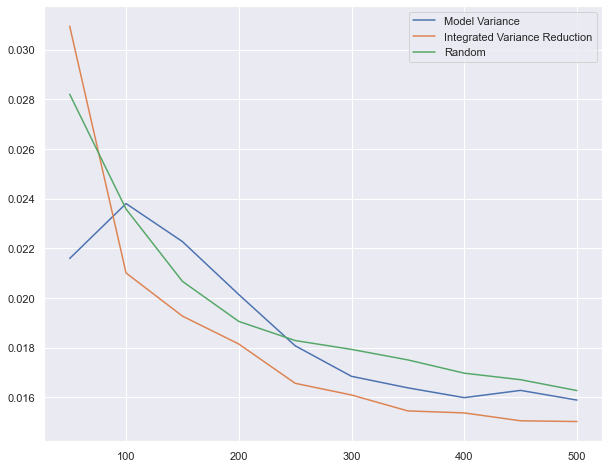

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
X_mv, Y_mv = zip(*mses_MV)
X_ivr, Y_ivr = zip(*mses_IVR)
X_rnd, Y_rnd = zip(*mses_RND)
ax.plot(X_mv, Y_mv, label='Model Variance')
ax.plot(X_ivr, Y_ivr, label='Integrated Variance Reduction')
ax.plot(X_rnd, Y_rnd, label='Random')
ax.legend()

### Save Models

In [37]:
with open(f'experimental_design/mmol/5param_model_variance_20_init_points_500_loops_timeloss_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_mv, f)

with open(f'experimental_design/mmol/5param_integrated_variance_reduction_20_init_points_500_loops_timeloss_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_ivr, f)
        
with open(f'experimental_design/mmol/5param_520_random_points_supervised_GP_timeloss_per_duration.pkl', "wb") as f:
     pickle.dump(emukit_model_rnd, f)
        
with open(f'experimental_design/mmol/mses.pkl', 'wb') as f:
    pickle.dump((mses_MV, mses_IVR, mses_RND), f)